### To note: Running this on different systems (i.e. local, SCW, server) will result in slight changes needing to the code

In [1]:
# Load libraries
import os
import numpy as np
import torch
import sys
import torchvision
import torchvision.transforms as T
import torchvision.models as models
from PIL import Image
from PIL import ImageEnhance
import matplotlib.pyplot as plt
import imagesize
import subprocess
sys.path
from IPython.core.debugger import set_trace
import scipy.ndimage
import matplotlib.patches as patches
# plt.rcParams['figure.figsize'] = [12,12]
# sys.path.append('/workspace/myFile/Mask_RCNN_Tutorial/')
from tqdm import tqdm
from torch import nn as nn
from torch import optim as optim
from torch.optim import lr_scheduler
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
import re
import time
import copy
import pylab
from torch.utils.tensorboard import SummaryWriter
from tempfile import TemporaryDirectory
import torch.backends.cudnn as cudnn
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import seaborn as sn
import pandas as pd
import glob
# Rather than have a messy notebook with a load of functions we can store them in separate .py files and import them

cudnn.benchmark = True
plt.ion()   # interactive mode

/opt/conda/lib/python3.8/site-packages/scipy/__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.4)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


In [2]:

writer = SummaryWriter("Experiments/TENSORBOARD")    # This determines the tensorboard file name

In [3]:
class DNADataset(object):
    def __init__(self, root, transforms, labels, imDx = False):
        self.root, self.transforms, self.labels = root, transforms, labels
    
        # load all image files, sorting them to ensure they are aligned
        self.imgDir = glob.glob(root+"*/*.tiff")
        Damagednuclei= [x for x in self.imgDir if 'Damaged_nuclei_' in x]
        Undamagednuclei= [x for x in self.imgDir if "No_damage_nuclei" in x]
        np.random.shuffle(Undamagednuclei)
        Undamagednuclei=Undamagednuclei[:10000]
        self.imgDir= Damagednuclei+Undamagednuclei
        size80=[]
        for x in self.imgDir:
            img = Image.open(x) # Open image
            w,h=img.size
            if w<=80 and h<=80:
                size80.append(x)
        self.imgDir=size80              
        
        self.imgs = sorted(self.imgDir) # list of images

        

        
    def __getitem__(self, idx):
        img_path = self.imgs[idx]
       
        # Transform images into tensors
        img = Image.open(img_path) # Open image
        w,h=img.size
        img = np.array(img) # Convert image into an array
        img = np.float32(np.divide(img, 2**16)) # Ensure all values are floats
        
        result=np.zeros((80,80), dtype=np.float32)
        x_center = (80 - w) // 2
        y_center = (80 - h) // 2 # copy img image into center of result image
        result[y_center:y_center+h, x_center:x_center+w] = img
        img = result
        
        targetlab=""
        if img_path.find('No_damage_nuclei') != -1:
            targetlab= 'Undamaged'
        if img_path.find('Damaged_nuclei_') != -1:
            targetlab= 'Damaged'  # Find labels corresponding to image
        target = self.labels.index(targetlab) # Get the label and assign to a value
        
        # Convert label to tensor
        #torch.to
        
        if self.transforms is not None:
            img = self.transforms(img)
#             #print('In the transforms')
        imNo = idx
        return img, target, imNo
        
    def __len__(self):
        return len(self.imgs)
 

In [4]:
root="/workspace/myFile/Output/17052023/"
p= glob.glob(root+"*/*.tiff")
Damagednuclei= [x for x in p if 'Damaged_nuclei_' in x]
Undamagednuclei= [x for x in p if "No_damage_nuclei" in x]
np.random.shuffle(Undamagednuclei)
Undamagednuclei=Undamagednuclei[:10000]
Undamagednuclei

['/workspace/myFile/Output/17052023/A0401/No_damage_nuclei_122.tiff',
 '/workspace/myFile/Output/17052023/A1118/No_damage_nuclei_552.tiff',
 '/workspace/myFile/Output/17052023/B0520/No_damage_nuclei_4.tiff',
 '/workspace/myFile/Output/17052023/F1003/No_damage_nuclei_20.tiff',
 '/workspace/myFile/Output/17052023/E1012/No_damage_nuclei_210.tiff',
 '/workspace/myFile/Output/17052023/F0625/No_damage_nuclei_158.tiff',
 '/workspace/myFile/Output/17052023/A0404/No_damage_nuclei_48.tiff',
 '/workspace/myFile/Output/17052023/B0413/No_damage_nuclei_26.tiff',
 '/workspace/myFile/Output/17052023/E0506/No_damage_nuclei_20.tiff',
 '/workspace/myFile/Output/17052023/D0413/No_damage_nuclei_114.tiff',
 '/workspace/myFile/Output/17052023/A1111/No_damage_nuclei_252.tiff',
 '/workspace/myFile/Output/17052023/F0613/No_damage_nuclei_134.tiff',
 '/workspace/myFile/Output/17052023/C1220/No_damage_nuclei_3.tiff',
 '/workspace/myFile/Output/17052023/A1210/No_damage_nuclei_127.tiff',
 '/workspace/myFile/Output/1

In [5]:
imDr = "/workspace/myFile/Output/17052023/"  # Image patches directory

labels = ['Damaged', 'Undamaged']  # Your labels

In [6]:
# For data augmentation
def get_transform(train):
    transforms = []

    transforms.append(T.ToTensor())
    transforms.append(T.Normalize([0.0019368887995516483], [0.00672996630111016]))
    #transforms.append(T.RandomHorizontalFlip(0.5))
    
    if train:
        transforms.append(T.RandomHorizontalFlip())
        transforms.append(T.RandomVerticalFlip())
    
    return T.Compose(transforms)

In [7]:
def train_model(model, criterion, optimizer, scheduler, dataloaderTrain, dataloaderTest, num_epochs=25):
    since = time.time()
    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                    dataloaders = dataloaderTrain
                else:
                    model.eval()   # Set model to evaluate mode
                    dataloaders = dataloaderTest

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels, imNo in dataloaders:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)
                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)    # Loss
                    running_corrects += torch.sum(preds == labels.data) # Accuracy

                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]    # Loss metric per epoch
                epoch_acc = running_corrects.double() / dataset_sizes[phase]    # Accuracy metric per epoch

                if phase == "train":    # This is the tensorboard code that writes accuracy and loss metrics
                    writer.add_scalar("Train/Accuracy", epoch_acc, epoch)
                    writer.add_scalar("Train/Loss", epoch_loss, epoch)
                else:
                    writer.add_scalar("Validation/Accuracy", epoch_acc, epoch)
                    writer.add_scalar("Validation/Loss", epoch_loss, epoch)

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc: 
                    # This compares validation accuracy to previous bests and adjusts model weights accordingly
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since  # Nice way to measure training time but info also stored (indirectly) by tensorboard
        print(
            f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')
        labels= labels.cpu().numpy()
        preds=preds.cpu().numpy()
        con_mat = confusion_matrix(labels, preds)   # Confusion matrix compares true class with predicted class
        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path))
    writer.close()
    return model, con_mat   # We want to return the model because its the model, also confusion matrix for later analysis


In [8]:
# This is your RESNET
# Initialize CNN with kaiming
def init_cnn(m):
    # Set the weights of the RESNET
    if getattr(m, 'bias', None) is not None: nn.init.constant_(m.bias, 0)
    if isinstance(m, (nn.Conv2d,nn.Linear)): nn.init.kaiming_normal_(m.weight)
    for l in m.children(): init_cnn(l)


# noop function for returning nothing
def noop(x): return x
# activation function(RELU)
act_fn = nn.ReLU(inplace=True)

# Flatten
class Flatten(nn.Module):
    def forward(self, x): return x.view(x.size(0), -1)

# Make a convolution
def conv(ni, nf, ks=3, stride=1, bias=False):
    return nn.Conv2d(ni, nf, kernel_size=ks, stride=stride, padding=ks//2, bias=bias)

# Create a convuolutional layer with convolution and batch norm
def conv_layer(ni, nf, ks=3, stride=1, zero_bn=False, act=True):
    bn = nn.BatchNorm2d(nf) # get a 2d batch norm from Pytorhc
    nn.init.constant_(bn.weight, 0. if zero_bn else 1.)
    layers = [conv(ni, nf, ks, stride=stride), bn]
    if act: layers.append(act_fn) # add in the activation function if act is true
    return nn.Sequential(*layers)


# Resblock
class ResBlock(nn.Module):
    def __init__(self, expansion, ni, nh, stride = 1):
        super().__init__()
        # ni - number of inputs channels, nf - number of filters
        # nh - number of filters in first conv
        # expansion is 1 for resnet 18, 34 and 4 for larger networks
        nf, ni = nh*expansion, ni*expansion
        layers = [conv_layer(ni, nh, 3, stride = stride), # for resnet < 34 2 convs per resblock
                 conv_layer(nh, nf, 3, zero_bn = True, act = False)
                 ] if expansion == 1 else [ # for RESNET > 34 then 3 convs per block with bottleneck
                            conv_layer(ni, nh, 1),
                            conv_layer(nh, nh, 3, stride = stride),
                            conv_layer(nh, nf, 1, zero_bn = True, act = False)
        ]
        self.convs = nn.Sequential(*layers) # Creates the conv layers
        self.idconv = noop if ni==nf else conv_layer(ni, nf, 1, act = False) # id convolution ()
        self.pool = noop if stride== 1 else nn.AvgPool2d(2, ceil_mode = True) # average pool on 
        
    def forward(self, x): 
        # Forward function adds the convolution part to the id part 
        #return act_fn(self.convs(x)) + self.idconv(self.pool(x))
        return act_fn(self.convs(x) + self.idconv(self.pool(x)))

# XResnet
class XResNet(nn.Sequential):
    @classmethod
    def create(cls, expansion, layers, c_in=3, c_out=1000):
        nfs = [c_in, (c_in + 1)*8, 64, 64] # number of filters in stem layer (c_in is number of image channels)
        stem = [conv_layer(nfs[i], nfs[i+1], stride=2 if i==0 else 1)
            for i in range(3)]

        nfs = [64//expansion,64,128,256,512]
        res_layers = [cls._make_layer(expansion, nfs[i], nfs[i+1],
                                      n_blocks=l, stride=1 if i==0 else 2)
                  for i,l in enumerate(layers)]
        res = cls(
        *stem,
        nn.MaxPool2d(kernel_size=3, stride = 2, padding = 1), # then a max pooling layer
        *res_layers,
        nn.AdaptiveAvgPool2d(1), Flatten(), 
        nn.Linear(nfs[-1]*expansion, c_out)
        )
        init_cnn(res)
        return res
        
    @staticmethod
    def _make_layer(expansion, ni, nf, n_blocks, stride): # returns a resblock
        return nn.Sequential(
        *[ResBlock(expansion, ni if i==0 else nf, nf, stride if i==0 else 1)
         for i in range(n_blocks)])

In [9]:

def xresnet18 (**kwargs): return XResNet.create(1, [2, 2,  2, 2], **kwargs)
def xresnet34 (**kwargs): return XResNet.create(1, [3, 4,  6, 3], **kwargs)
def xresnet50 (**kwargs): return XResNet.create(4, [3, 4,  6, 3], **kwargs)
model = xresnet18(c_in = 1, c_out = 2)
#model = xresnet34(c_in = 1, c_out = 2)
#model = xresnet50(c_in = 1, c_out = 2)
model = model.to(device)

# Label smoothing cross entropy
import torch.nn.functional as F


def reduce_loss(loss, reduction='mean'):
    return loss.mean() if reduction=='mean' else loss.sum() if reduction=='sum' else loss

class LabelSmoothingCrossEntropy(nn.Module):
    def __init__(self, ε:float=0.1, reduction='mean'):
        super().__init__()
        self.ε,self.reduction = ε,reduction
    
    def forward(self, output, target):
        c = output.size()[-1]
        log_preds = F.log_softmax(output, dim=-1)
        loss = reduce_loss(-log_preds.sum(dim=-1), self.reduction)
        nll = F.nll_loss(log_preds, target, reduction=self.reduction)
        return lin_comb(loss/c, nll, self.ε)

In [10]:
# Helper functions that shows the image, true class, predicted class and degree of prediction

def images_to_probs(net, images):
    '''
    Generates predictions and corresponding probabilities from a trained
    network and a list of images
    '''
    output = net(images)
    # convert output probabilities to predicted class
    _, preds_tensor = torch.max(output, 1)
    preds = np.squeeze(preds_tensor.numpy())
    return preds, [F.softmax(el, dim=0)[i].item() for i, el in zip(preds, output)]


def plot_classes_preds(net, images, labels):
    '''
    Generates matplotlib Figure using a trained network, along with images
    and labels from a batch, that shows the network's top prediction along
    with its probability, alongside the actual label, coloring this
    information based on whether the prediction was correct or not.
    Uses the "images_to_probs" function.
    '''
    preds, probs = images_to_probs(net, images)
    # plot the images in the batch, along with predicted and true labels
    fig = plt.figure(figsize=(12, 48))
    for idx in np.arange(4):
        ax = fig.add_subplot(1, 4, idx+1, xticks=[], yticks=[])
        matplotlib_imshow(images[idx], one_channel=True)
        ax.set_title("{0}, {1:.1f}%\n(label: {2})".format(
            labels[preds[idx]],
            probs[idx] * 100.0,
            labels[labels[idx]]),
                    color=("green" if preds[idx]==labels[idx].item() else "red"))
    return fig

def matplotlib_imshow(img, one_channel=True):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

In [11]:
def confusion_matrix_calc(data_loader_test, classes, model_ft):       
        y_pred = []
        y_true = []
        for inputs, labels, imNo in data_loader_test:
                inputs = inputs.to(device)
                labels = labels.to(device)
                output = model_ft(inputs) # Feed Network

                output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
                y_pred.extend(output) # Save Prediction
                
                labels = labels.data.cpu().numpy()
                y_true.extend(labels) # Save Truth

        # constant for classes
        # classes = ('Alive', 'Dead')

        # Build confusion matrix
        cf_matrix = confusion_matrix(y_true, y_pred)
        return cf_matrix


In [12]:
torch.manual_seed(10)
imIdx = torch.randperm(101106).tolist()

## Create dataset
dataSetTrain = DNADataset(imDr, get_transform(train = True), labels, imDx=imIdx)
dataSetTest = DNADataset(imDr, get_transform(train = False), labels, imDx=imIdx)

# ## Create dataloaders
# Get subset
torch.manual_seed(10)
indices = torch.randperm(len(dataSetTrain)).tolist()

noTrain = int(len(dataSetTrain)*0.7)

dataset_train = torch.utils.data.Subset(dataSetTrain, indices[-noTrain:])
dataset_test = torch.utils.data.Subset(dataSetTest, indices[:-noTrain])
#len(indices), len(indices[:-50]), len(indices[-50:]), 50/191, type(dataset_test)

dataset_sizes = {'train': len(dataset_train), 'val': len(dataset_test)}

# define training and validation data loaders
data_loader_train = torch.utils.data.DataLoader(
    dataset_train, batch_size=20, shuffle=True, num_workers=0)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=0)


# Collate function (gathers together the outputs)
# def collate_fn(batch):
#     return tuple(zip(*batch))

len(indices[-noTrain:]), dataset_sizes
#dataset_test[0][1], dataset_test[3][1], dataset_test[-1][1], dataSetTrain.imgs

(13904, {'train': 13904, 'val': 5960})

In [13]:

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(model.parameters(), weight_decay=1e-2) # standard ADAM optimiser

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [14]:
model_ft, con_mat = train_model(model, criterion, optimizer_ft, exp_lr_scheduler,
                       data_loader_train,data_loader_test,num_epochs=20)

Epoch 0/19
----------
train Loss: 0.5697 Acc: 0.7207
val Loss: 0.5407 Acc: 0.7408

Epoch 1/19
----------
train Loss: 0.5130 Acc: 0.7619
val Loss: 0.5651 Acc: 0.7438

Epoch 2/19
----------
train Loss: 0.5002 Acc: 0.7704
val Loss: 0.6033 Acc: 0.6601

Epoch 3/19
----------
train Loss: 0.4824 Acc: 0.7798
val Loss: 0.4547 Acc: 0.7997

Epoch 4/19
----------
train Loss: 0.4724 Acc: 0.7795
val Loss: 0.5454 Acc: 0.7443

Epoch 5/19
----------
train Loss: 0.4645 Acc: 0.7879
val Loss: 0.4629 Acc: 0.7807

Epoch 6/19
----------
train Loss: 0.4638 Acc: 0.7868
val Loss: 0.5427 Acc: 0.7480

Epoch 7/19
----------
train Loss: 0.4383 Acc: 0.8072
val Loss: 0.4162 Acc: 0.8169

Epoch 8/19
----------
train Loss: 0.4306 Acc: 0.8068
val Loss: 0.6396 Acc: 0.6889

Epoch 9/19
----------
train Loss: 0.4258 Acc: 0.8122
val Loss: 0.4349 Acc: 0.8076

Epoch 10/19
----------
train Loss: 0.4273 Acc: 0.8080
val Loss: 0.7951 Acc: 0.6315

Epoch 11/19
----------
train Loss: 0.4229 Acc: 0.8156
val Loss: 0.4183 Acc: 0.8158

Ep

In [15]:
cf_matrix = confusion_matrix_calc(data_loader_test, labels, model_ft)

<AxesSubplot:>

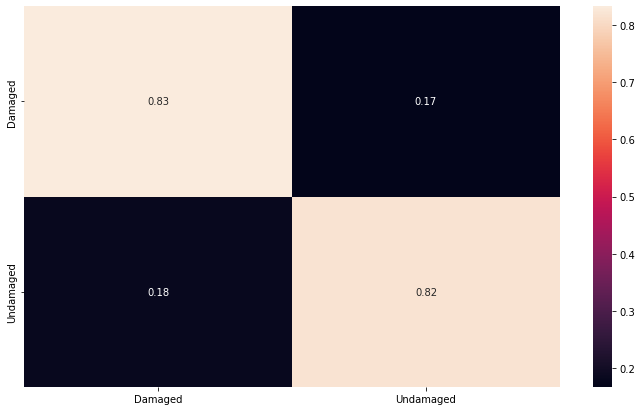

In [16]:
df_cm_ratio = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index=[i for i in labels],
                     columns=[i for i in labels])
plt.figure(figsize=(12, 7))
sn.heatmap(df_cm_ratio, annot=True)
# plt.save("Confusion_matrix_ratio.png")

<AxesSubplot:>

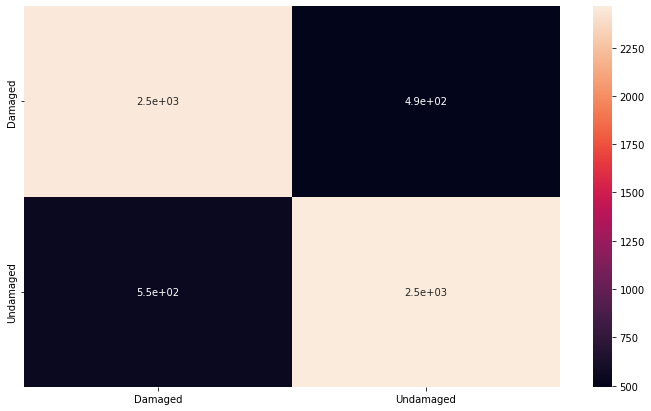

In [17]:
df_cm_raw = pd.DataFrame(cf_matrix, index=[i for i in labels],
                     columns=[i for i in labels])
plt.figure(figsize=(12, 7))
sn.heatmap(df_cm_raw, annot=True)
# plt.save("Confusion_matrix_raw.png")

In [18]:
cf_matrix

array([[2456,  494],
       [ 546, 2464]])